# Representational Rényi Heterogeneity: Supplemental Code for Proxy Measure of Similarity between MNIST Digits Using a Siamese Network

**Abraham Nunes, Martin Alda, Timothy Bardouille, and Thomas Trappenberg**

*Dalhousie University, Halifax, Nova Scotia, Canada*

We hypothesized that the class of Ones in the MNIST dataset constitute the most homogeneous digit class. Using a Siamese Neural Network, which learns a distance metric on latent features, we should thus observe that images in the class of Ones have the lowest pairwise distance of any class pairing in the MNIST dataset.

In [0]:
import os
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST 
from torch.autograd import Variable 
from torch.optim import lr_scheduler 
from torch import optim
from PIL import Image
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 13
import matplotlib.pyplot as plt

## Load Data and Create Dataset of Pairs

In [2]:
def load_mnist(fpath='./data/MNIST', batch_size=128):
    """ From https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb"""
    ftrans = transforms.Compose([transforms.ToTensor()])
    out = [DataLoader(MNIST(root=fpath, download=True, train=t, transform=ftrans), batch_size=batch_size, shuffle=False) for t in [True, False]]
    return out

train_dataloader, test_dataloader = load_mnist()

# Place into numpy arrays for easier manipulation
traindata = list(train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
Xtrain = np.vstack([sample[0] for sample in traindata])
ytrain = np.hstack([sample[1] for sample in traindata])

testdata = list(test_dataloader)
testdata = [[sample[0].numpy(), sample[1].numpy()] for sample in testdata]
Xtest = np.vstack([sample[0] for sample in testdata])
ytest = np.hstack([sample[1] for sample in testdata])

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20165602.24it/s]                            


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


32768it [00:00, 329781.20it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


1654784it [00:00, 5266443.65it/s]                           
8192it [00:00, 128761.94it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw
Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


In [0]:
class SiameseNetMNISTData():
    def __init__(self, train=True, rng=np.random.RandomState(2436)):
        self.ftrans = transforms.Compose([transforms.ToTensor()])
        self.train = train
        self.rng = rng
        if train:
            self.images = Xtrain
            self.labels = ytrain
        else:
            self.images = Xtest 
            self.labels = ytest
        self.idx1 = np.arange(len(self.images))
        self.idx2 = np.arange(len(self.images))
        self.rng.shuffle(self.idx1)
        self.rng.shuffle(self.idx2)

        self.digit = 0
        self.same_digit = True

    def increment_digit(self):
        if self.digit == 9:
            self.digit = 0
        else: 
            self.digit += 1

    def __getitem__(self, index):
        currdigitset_idx = np.argwhere(self.labels == self.digit).flatten()
        currdigit_idx = self.rng.choice(currdigitset_idx)
        img1, label1 = self.images[currdigit_idx], self.labels[currdigit_idx]
        if self.same_digit:
            pair_idx = self.rng.choice(currdigitset_idx)
            img2, label2 = self.images[pair_idx], self.labels[pair_idx]
            same_image = torch.from_numpy(np.array([1.0]))
            self.same_digit = False
        else:
            otherdigitset_idx = np.argwhere(self.labels != self.digit).flatten()
            otherdigit_idx = self.rng.choice(otherdigitset_idx)
            img2, label2 = self.images[otherdigit_idx], self.labels[otherdigit_idx]
            same_image = torch.from_numpy(np.array([0.0]))
            self.same_digit = True 
            self.increment_digit()
        return img1, img2, same_image, label1, label2

    def __len__(self):
        return len(self.images)#len(self.idx_keep)


## Define Siamese Network

Based on code from https://innovationincubator.com/siamaese-neural-network-with-paytorch-code-example/

In [0]:
c = 64
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, c, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            nn.Conv2d(c, c*2, kernel_size=4,stride=2,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.1))
        self.fcn = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 16))
        
    def f(self, x):
        out = self.cnn(x)
        return self.fcn(out.view(out.size()[0], -1))

    def forward(self, x1, x2):
        return self.f(x1), self.f(x2)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=10.0):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, z1, z2, y):
        Dz = F.pairwise_distance(z1, z2)
        A = (1-y)*torch.pow(Dz, 2)/2
        B = y*torch.pow(torch.clamp(self.m-Dz, min=0.0),2)/2
        return torch.mean(A + B)

## Training

In [5]:
Dtrain = DataLoader(SiameseNetMNISTData(train=False),
                    shuffle=False, 
                    batch_size=10000)

siamesenet = SiameseNet().cuda()
f_loss = ContrastiveLoss()
opt = optim.Adam(siamesenet.parameters(), lr=1e-4)

def train_siamese_network():    
    image1, image2, label, y1, y2 = next(iter(Dtrain))
    image1, image2, label = image1.cuda(), image2.cuda() , label.cuda()
    embedding1,embedding2 = siamesenet(image1,image2)
    loss = f_loss(embedding1,embedding2,label)
    print("INITIAL LOSS {}".format(loss.item()))
    for niter in range(0,100):
        for i, data in enumerate(Dtrain,0):
            image1, image2 , label, y1, y2 = data
            image1, image2 , label = image1.cuda(), image2.cuda() , label.cuda()
            opt.zero_grad()
            embedding1,embedding2 = siamesenet(image1,image2)
            loss = f_loss(embedding1,embedding2,label)
            loss.backward()
            opt.step()
        if niter % 10 ==0:
            print("ITER %s | LOSS %s" %(niter,loss.item()))
    return siamesenet

model = train_siamese_network()

INITIAL LOSS 23.76428924929783
ITER 0 | LOSS 23.76766501167535
ITER 10 | LOSS 22.24468418619597
ITER 20 | LOSS 20.306901314488776
ITER 30 | LOSS 18.04695784118487
ITER 40 | LOSS 15.760083298950132
ITER 50 | LOSS 13.940440173550861
ITER 60 | LOSS 13.158395904346103
ITER 70 | LOSS 13.128708283276895
ITER 80 | LOSS 13.122633914480437
ITER 90 | LOSS 13.090911509269377


## Plot the Empirical Cumulative Distributions for Embedded Distance between Digit Class Pairs 

In [0]:
Dtest = DataLoader(SiameseNetMNISTData(train=True),
                   shuffle=False, 
                   batch_size=50000)

image1, image2 , label, y1, y2 = next(iter(Dtest))
image1, image2 , label = image1.cuda(), image2.cuda() , label.cuda()
embedding1,embedding2 = siamesenet(image1,image2)
d = embedding1.cpu().detach().numpy()-embedding2.cpu().detach().numpy()
d = np.linalg.norm(d, axis=1).flatten()
Z = np.hstack((d.reshape(-1, 1), label.cpu().detach().numpy().reshape(-1, 1), 
               y1.numpy().reshape(-1, 1), y2.numpy().reshape(-1, 1)))


res = pd.DataFrame(Z[np.argsort(Z[:,0])], columns=['Distance', 'Same Class', 'Digit A', 'Digit B'])
res['Rank'] = np.arange(res.shape[0])
res['Digit A'] = res['Digit A'].values.astype(np.int)
res['Digit B'] = res['Digit B'].values.astype(np.int)
res['Class'] = ["%s-%s" %(res['Digit A'].values[i], res['Digit B'].values[i]) for i in range(res.shape[0])]

In [0]:
S = np.zeros((res.shape[0], 10))
for j in range(10):
    currcol = "%s-%s" %(j,j)
    S[:,j] = (res['Class'].values == currcol).astype(np.float32)
S = S/np.tile(S.sum(0), [res.shape[0], 1])
S = np.cumsum(S, axis=0)

V = np.zeros((res.shape[0], 2))
for j in range(2):
    V[:,j] = (res['Same Class'].values == j).astype(np.float32)
V = V/np.tile(V.sum(0), [res.shape[0], 1])
V = np.cumsum(V, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  import sys
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


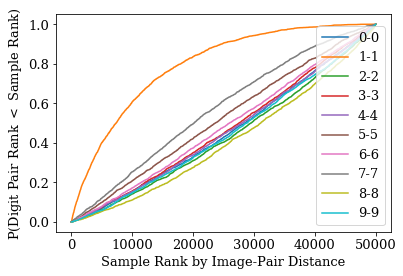

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('Sample Rank by Image-Pair Distance')
ax.set_ylabel(r'P(Digit Pair Rank $<$ Sample Rank)')
for i in range(10):
    ax.plot(np.arange(S.shape[0]), S[:,i], label="%s-%s" %(i,i))
plt.legend()
plt.savefig('rank-accumulation-curve.pdf', bbox_inches="tight")


In [0]:
def cumulation_curve(x, event):
    e = (x == event).astype(np.float32)
    return np.cumsum(e/e.sum())

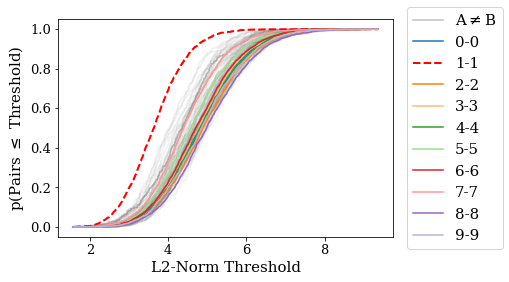

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(10):
    for j in range(10):
        if np.logical_not(np.equal(i,j)):
            if i==0 and j==1:
                ax.plot(res['Distance'], 
                        cumulation_curve(res['Class'], '%s-%s' %(i,j)), 
                        c='gray', alpha=0.5, label=r'A$\neq$B')
            else: 
                ax.plot(res['Distance'], 
                        cumulation_curve(res['Class'], '%s-%s' %(i,j)), 
                        c='gray', alpha=0.1)
            
ax.set_ylabel(r'p(Pairs $\leq$ Threshold)', fontsize=15)
ax.set_xlabel(r'L2-Norm Threshold', fontsize=15)
for i in range(10):
    if i != 1:
        ax.plot(res['Distance'], S[:,i], label="%s-%s" %(i,i), 
                c=plt.get_cmap("tab20")(i))   
    else: 
        ax.plot(res['Distance'], 
        cumulation_curve(res['Class'], '1-1'), 
        c='r', ls="--", lw=2, label='1-1')       


plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=15)
plt.savefig('rank-accumulation-curve-dist-all.pdf', bbox_inches="tight")